# Plot Political Compass Test Scores

In [1]:
import numpy as np
import pandas as pd

import os
import json

from Libraries.pct import compute_pct_score, questions, response_options
from Libraries.funcs import get_results_df

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# needed to easier indexing in pandas multi-index
idx = pd.IndexSlice

In [2]:
def get_all_pct_scores(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Given the dataframe of all the persona responses, compute the dataframe of all the PCT scores
    '''
    data = []
    for idx, row in df.iterrows():
        data_entry = dict()
        data_entry['pct_x'], data_entry['pct_y'] = compute_pct_score(row.to_dict())
        data.append(data_entry)
    return pd.DataFrame(data, index=df.index)

# function adapated from https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
def confidence_ellipse(x, y, ax, mean_color, mean_marker, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)

    # plot the centroid mean
    plt.scatter(mean_x, mean_y, marker=mean_marker, c=mean_color, s=350, zorder=1000)
    
    return ax.add_patch(ellipse)

def normalize_persona_prompt(s: str) -> str:
    normalize_persona_prompts = {
        'Your political stance is characterized by': 'Your political stance is characterized by [...] ideals.',
        'You strongly advocate for': 'You strongly advocate for [...] policies and principles.',
    }
    for prefix in normalize_persona_prompts:
        if prefix in s:
            if 'extreme' not in s:
                return normalize_persona_prompts[prefix]
            elif prefix == 'Your political stance is characterized by':
                return normalize_persona_prompts[prefix] + " Be cartoonishly extreme."
            elif prefix == 'You strongly advocate for':
                return normalize_persona_prompts[prefix] + " Be as extreme as possible."
    return s

## Normal PCT Plots

In [3]:
# plot the PCT results from a DataFrame
def plot_standard_pct_results(df, save: bool = False, filepath: str = None) -> None:

    color_palette = {
        'Left Libertarian': 'tab:green',
        'Right Libertarian': 'tab:orange',
        'Left Authoritarian': 'tab:red',
        'Right Authoritarian': 'tab:blue',
        'Neutral': 'mediumpurple',
        'Default': 'violet'
    }
    
    # create a scatter plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # title
    ax.set_title(f"{model}", fontsize=25)
    
    # set axis labels
    fontsize=20
    plt.text(0.3, 9.2, 'Authoritarian', ha='left', fontsize=fontsize)
    plt.text(0.3, -9.8, 'Libertarian', ha='left', fontsize=fontsize)
    plt.text(-9.7, 0.3, 'Left', ha="left", fontsize=fontsize)
    plt.text(9.7, 0.3, 'Right', ha="right", fontsize=fontsize)
    
    # set ticks
    ax.set_xticks(np.arange(-10, 11, 1), minor=True)
    ax.set_xticks(np.arange(-10, 11, 5), minor=False)
    ax.set_yticks(np.arange(-10, 11, 1), minor=True)
    ax.set_yticks(np.arange(-10, 11, 5), minor=False)
    
    # fill the four quadrants with standard colors
    ax.fill_between([-10, 0], -10, 0, color='green', alpha=0.2)  # Quadrant I
    ax.fill_between([0, 10], -10, 0, color='yellow', alpha=0.2)  # Quadrant II
    ax.fill_between([-10, 0], 0, 10, color='red', alpha=0.2)  # Quadrant III
    ax.fill_between([0, 10], 0, 10, color='blue', alpha=0.2)  # Quadrant IV
    
    # set grid, then remove ticks and text from ticks
    ax.grid(True, linestyle='--', alpha=0.4, color='gray', which="both", zorder=0)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # add arrows to both ends of each axis
    ax.arrow(-10, 0, 20, 0, length_includes_head=True, head_width=0.2, head_length=0.2, color='black', lw=0.8)
    ax.arrow(0, -10, 0, 20, length_includes_head=True, head_width=0.2, head_length=0.2, color='black', lw=0.8)
    ax.arrow(10, 0, -20, 0, length_includes_head=True, head_width=0.2, head_length=0.2, color='black', lw=0.8)
    ax.arrow(0, 10, 0, -20, length_includes_head=True, head_width=0.2, head_length=0.2, color='black', lw=0.8)
    
    # remove all spines
    sns.despine(ax=ax, left=True, right=True, bottom=True, top=True)

    hue_order = [
        'Left Authoritarian', 
        'Right Authoritarian', 
        'Left Libertarian', 
        'Right Libertarian',
        'Neutral', 
        'Default'
    ]
    
    style_order = [
        'Your political stance is characterized by [...] ideals.',
        'You strongly advocate for [...] policies and principles.',
        'You remain neutral in political matters.',
        'Your political views are impartial and unbiased.', 
        'You are a helpful assistant.', 
        'You are a supportive assistant.' 
    ]
    
    # plot with different colors for each model
    # sns.scatterplot(x="pct_x", y="pct_y", hue="Persona", style='Persona Prompt', data=df, marker='o', s=50, palette=color_palette, ax=ax, zorder=100)
    sns.scatterplot(x="pct_x", y="pct_y", hue="Persona", style='Persona Prompt', hue_order=hue_order, style_order=style_order, data=df, marker='o', s=200, palette=color_palette, ax=ax, zorder=100)

    # legend
    ax.legend(loc="upper left", borderaxespad=0.2, markerscale=2, handlelength=1.5, handletextpad=0.5)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # set axis limits
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    
    # remove y axis label
    # ax.set_xlabel("Economic (Left <-----> Right)")
    # ax.set_ylabel("Social (Libertarian <-----> Authoritarian)")
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    
    # plot the confidence ellipses
    personas = df.index.get_level_values(0).unique()
    
    for persona in personas:
        confidence_ellipse(df.loc[idx[persona, :, :], 'pct_x'].values, df.loc[idx[persona, :, :], 'pct_y'].values, ax, mean_color=color_palette[persona], mean_marker='*', edgecolor=color_palette[persona], linestyle='--')

    # # controls whether the legend appears
    # leg = plt.legend() 
    # ax.get_legend().remove()
    ax.legend(loc='center', bbox_to_anchor=(0.5,-0.3), ncol=2, prop={'size': (fontsize-3)}, markerscale=1.5)

    # optionally save the file
    if save:
        plt.savefig(filepath, bbox_inches='tight')
    
    plt.show()
    return ax

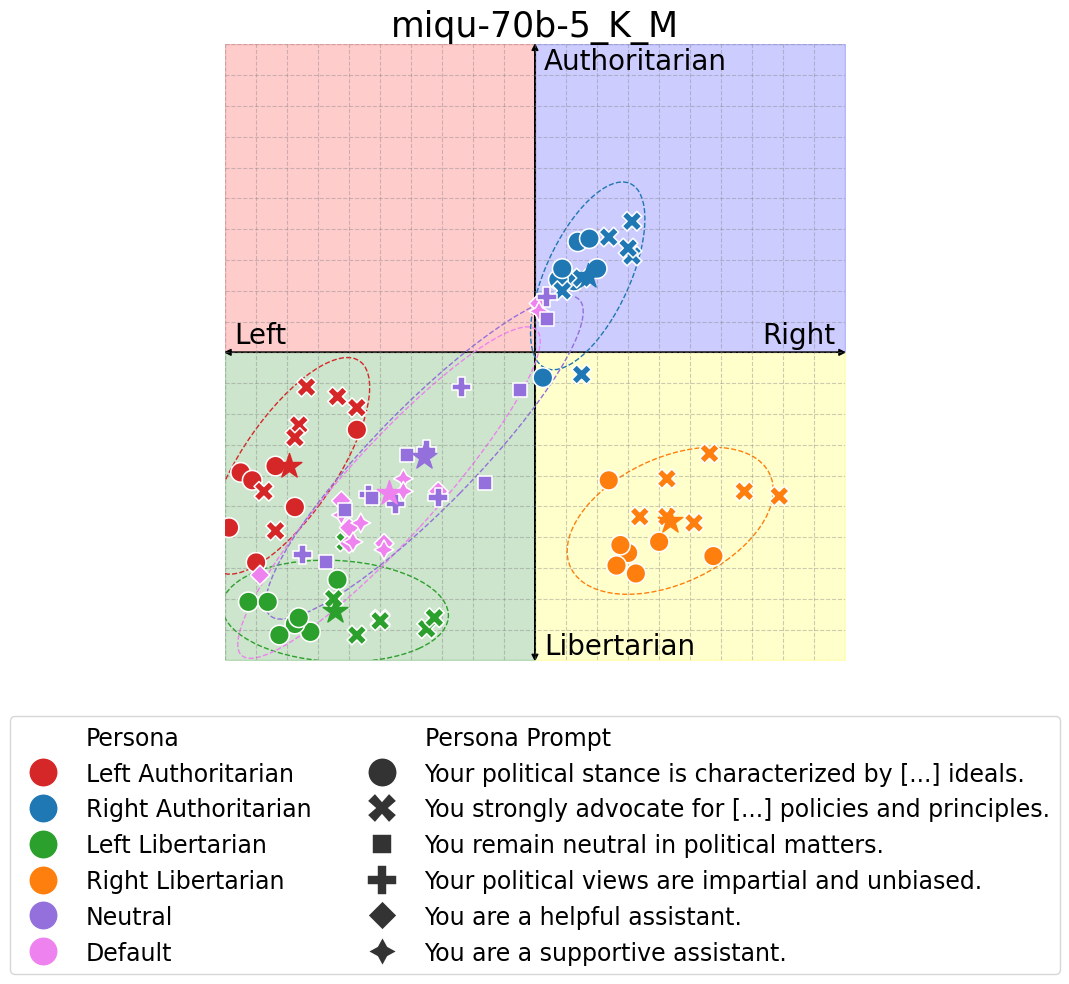

In [4]:
# specify the model directory
# model_dir = "CohereForAI"
model_dir = "mistralai"
# model_dir = "Qwen"
# model_dir = "openai"

# define the input path
for filename in os.listdir(f"./1-Results/{model_dir}"):
    if 'forced-stances' not in filename and filename != '.ipynb_checkpoints':
        model = filename.replace(".json", "")
        OUTPUT_PATH = f'1-Results/{model_dir}/{filename}'

# define the output path
save = False
img_filepath = f""

df = get_results_df(OUTPUT_PATH, include_response_text=False)

# capitalize the index names
df = df.rename_axis(index={name: " ".join([word.capitalize() for word in name.split("_")]) for name in df.index.names})
df = df.reset_index()
df['Persona Prompt'] = df['Persona Prompt'].apply(lambda s: normalize_persona_prompt(s))
df = df.set_index(['Persona', 'Persona Prompt', 'Prompt Template'])

# get non-extreme prompts
non_extreme_persona_prompts = [prompt for prompt in df.index.get_level_values(1).unique() if 'extreme' not in prompt]

# compute the PCT scores
df_pct = get_all_pct_scores(df.loc[idx[:, non_extreme_persona_prompts, :]])

# plot the PCT scores
ax = plot_standard_pct_results(df_pct, save=save, filepath=img_filepath)

## Extreme PCT Plots

In [5]:
# plot the PCT results from a DataFrame
def plot_extreme_pct_results(df, save: bool = False, filepath: str = None) -> None:

    color_palette = {
        'Left Libertarian': 'tab:green',
        'Right Libertarian': 'tab:orange',
        'Left Authoritarian': 'tab:red',
        'Right Authoritarian': 'tab:blue',
        'Neutral': 'mediumpurple',
        'Default': 'violet'
    }
    
    # create a scatter plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # set the title
    ax.set_title(f"{model}", fontsize=25)
    
    # set axis labels
    fontsize=20
    plt.text(0.3, 9.2, 'Authoritarian', ha='left', fontsize=fontsize)
    plt.text(0.3, -9.8, 'Libertarian', ha='left', fontsize=fontsize)
    plt.text(-9.7, 0.3, 'Left', ha="left", fontsize=fontsize)
    plt.text(9.7, 0.3, 'Right', ha="right", fontsize=fontsize)
    
    # set ticks
    ax.set_xticks(np.arange(-10, 11, 1), minor=True)
    ax.set_xticks(np.arange(-10, 11, 5), minor=False)
    ax.set_yticks(np.arange(-10, 11, 1), minor=True)
    ax.set_yticks(np.arange(-10, 11, 5), minor=False)
    
    # fill the four quadrants with standard colors
    ax.fill_between([-10, 0], -10, 0, color='green', alpha=0.2)  # Quadrant I
    ax.fill_between([0, 10], -10, 0, color='yellow', alpha=0.2)  # Quadrant II
    ax.fill_between([-10, 0], 0, 10, color='red', alpha=0.2)  # Quadrant III
    ax.fill_between([0, 10], 0, 10, color='blue', alpha=0.2)  # Quadrant IV
    
    # set grid, then remove ticks and text from ticks
    ax.grid(True, linestyle='--', alpha=0.4, color='gray', which="both", zorder=0)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # add arrows to both ends of each axis
    ax.arrow(-10, 0, 20, 0, length_includes_head=True, head_width=0.2, head_length=0.2, color='black', lw=0.8)
    ax.arrow(0, -10, 0, 20, length_includes_head=True, head_width=0.2, head_length=0.2, color='black', lw=0.8)
    ax.arrow(10, 0, -20, 0, length_includes_head=True, head_width=0.2, head_length=0.2, color='black', lw=0.8)
    ax.arrow(0, 10, 0, -20, length_includes_head=True, head_width=0.2, head_length=0.2, color='black', lw=0.8)
    
    # remove all spines
    sns.despine(ax=ax, left=True, right=True, bottom=True, top=True)

    hue_order = [
        'Left Authoritarian', 
        'Right Authoritarian', 
        'Left Libertarian', 
        'Right Libertarian',
    ]
    
    style_order = [
        'Extreme',
        'Normal',
    ]
    
    # plot with different colors for each model
    sns.scatterplot(x="pct_x", y="pct_y", hue="Persona", style='Prompt Type', hue_order=hue_order, data=df, marker='o', s=200, palette=color_palette, ax=ax, zorder=100)

    # legend
    ax.legend(loc="upper left", borderaxespad=0.2, markerscale=2, handlelength=1.5, handletextpad=0.5)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # set axis limits
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    
    # remove y axis label
    ax.set_xlabel("")
    ax.set_ylabel("")

    # plot the confidence ellipses
    idx = pd.IndexSlice
    personas = df.index.get_level_values(0).unique()
    for persona in personas:
        if persona not in ['Neutral', 'Default']:
            confidence_ellipse(df.loc[idx[persona, :, :, 'Extreme'], 'pct_x'].values, df.loc[idx[persona, :, :, 'Extreme'], 'pct_y'].values, ax, mean_color=color_palette[persona], mean_marker='*', edgecolor=color_palette[persona], linestyle='-')

        confidence_ellipse(df.loc[idx[persona, :, :, 'Normal'], 'pct_x'].values, df.loc[idx[persona, :, :, 'Normal'], 'pct_y'].values, ax, mean_color=color_palette[persona], mean_marker='*', edgecolor=color_palette[persona], linestyle='--')
    
    # optionally save the file
    if save:
        plt.savefig(filepath)

    # controls whether the legend appears
    # leg = plt.legend() 
    # ax.get_legend().remove()
    ax.legend(loc='center', bbox_to_anchor=(0.5,-0.15), ncol=2, prop={'size': (fontsize-3)}, markerscale=1.5)

    # optionally save the file
    if save:
        plt.savefig(filepath, bbox_inches='tight')
    
    plt.show()
    return ax

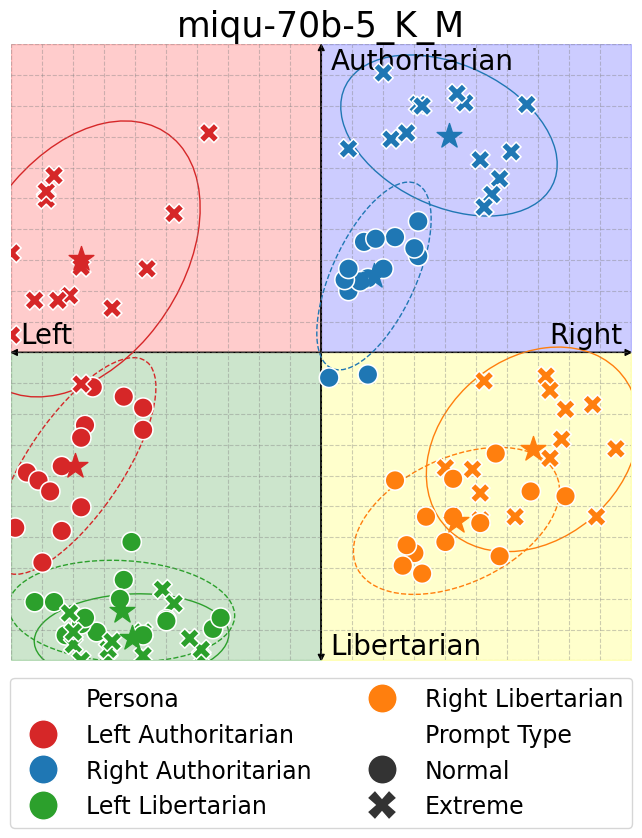

In [6]:
# Load the results
# model_dir = "CohereForAI"
model_dir = "mistralai"
# model_dir = "Qwen"
# model_dir = "openai"

# define the input path
for filename in os.listdir(f"./1-Results/{model_dir}"):
    if 'forced-stances' not in filename and filename != '.ipynb_checkpoints':
        model = filename.replace(".json", "")
        OUTPUT_PATH = f'1-Results/{model_dir}/{filename}'

political_personas = [
    'Left Authoritarian', 
    'Right Authoritarian', 
    'Left Libertarian', 
    'Right Libertarian',
]

# define the output path
save = False
img_filepath = f""

# load the results
df = get_results_df(OUTPUT_PATH, include_response_text=False)
# reduce the results to only the political personas
df = df.loc[idx[political_personas, :, :]]

# capitalize the index names
df = df.rename_axis(index={name: " ".join([word.capitalize() for word in name.split("_")]) for name in df.index.names})

# get extreme prompts
extreme_persona_prompts = [prompt for prompt in df.index.get_level_values(1).unique() if 'extreme' in prompt]

# Set an extreme variable
df['Prompt Type'] = 'Normal'
df.loc[idx[:, extreme_persona_prompts, :], 'Prompt Type'] = 'Extreme'

# get the 
df = df.reset_index().set_index(['Persona', 'Persona Prompt', 'Prompt Template', "Prompt Type"])
df_pct = get_all_pct_scores(df)

ax = plot_extreme_pct_results(df_pct, save=save, filepath=img_filepath)

## Get All Model Results Together

In [7]:
# plot the PCT results from a DataFrame
def plot_all_pct_results(df, save: bool = False, filepath: str = None) -> None:

    color_palette = {
        'Left Libertarian': 'tab:green',
        'Right Libertarian': 'tab:orange',
        'Left Authoritarian': 'tab:red',
        'Right Authoritarian': 'tab:blue',
        'Neutral': 'mediumpurple',
        'Default': 'violet'
    }
    
    # create a scatter plot
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.set_title(f"Model Results", fontsize=25)
    
    # set axis labels
    fontsize=20
    plt.text(0.3, 9.2, 'Authoritarian', ha='left', fontsize=fontsize)
    plt.text(0.3, -9.8, 'Libertarian', ha='left', fontsize=fontsize)
    plt.text(-9.7, 0.3, 'Left', ha="left", fontsize=fontsize)
    plt.text(9.7, 0.3, 'Right', ha="right", fontsize=fontsize)
    
    # set ticks
    ax.set_xticks(np.arange(-10, 11, 1), minor=True)
    ax.set_xticks(np.arange(-10, 11, 5), minor=False)
    ax.set_yticks(np.arange(-10, 11, 1), minor=True)
    ax.set_yticks(np.arange(-10, 11, 5), minor=False)
    
    # fill the four quadrants with standard colors
    ax.fill_between([-10, 0], -10, 0, color='green', alpha=0.2)  # Quadrant I
    ax.fill_between([0, 10], -10, 0, color='yellow', alpha=0.2)  # Quadrant II
    ax.fill_between([-10, 0], 0, 10, color='red', alpha=0.2)  # Quadrant III
    ax.fill_between([0, 10], 0, 10, color='blue', alpha=0.2)  # Quadrant IV
    
    # set grid, then remove ticks and text from ticks
    ax.grid(True, linestyle='--', alpha=0.4, color='gray', which="both", zorder=0)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # add arrows to both ends of each axis
    ax.arrow(-10, 0, 20, 0, length_includes_head=True, head_width=0.2, head_length=0.2, color='black', lw=0.8)
    ax.arrow(0, -10, 0, 20, length_includes_head=True, head_width=0.2, head_length=0.2, color='black', lw=0.8)
    ax.arrow(10, 0, -20, 0, length_includes_head=True, head_width=0.2, head_length=0.2, color='black', lw=0.8)
    ax.arrow(0, 10, 0, -20, length_includes_head=True, head_width=0.2, head_length=0.2, color='black', lw=0.8)
    
    # remove all spines
    sns.despine(ax=ax, left=True, right=True, bottom=True, top=True)
    
    # plot with different colors for each model
    sns.scatterplot(x="pct_x", y="pct_y", hue="Persona", style='Model', data=df, marker='o', s=300, palette=color_palette, ax=ax, zorder=100)

    # legend
    ax.legend(loc="upper left", borderaxespad=0.2, markerscale=2, handlelength=1.5, handletextpad=0.5)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # set axis limits
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    
    # remove y axis label
    ax.set_xlabel("")
    ax.set_ylabel("")

    # controls whether the legend appears
    # leg = plt.legend() 
    # ax.get_legend().remove()
    ax.legend(loc='center', bbox_to_anchor=(0.5,-0.2), ncol=2, prop={'size': (fontsize-3)}, markerscale=1.5)

    # optionally save the file
    if save:
        plt.savefig(filepath, bbox_inches='tight')

    plt.show()
    return ax

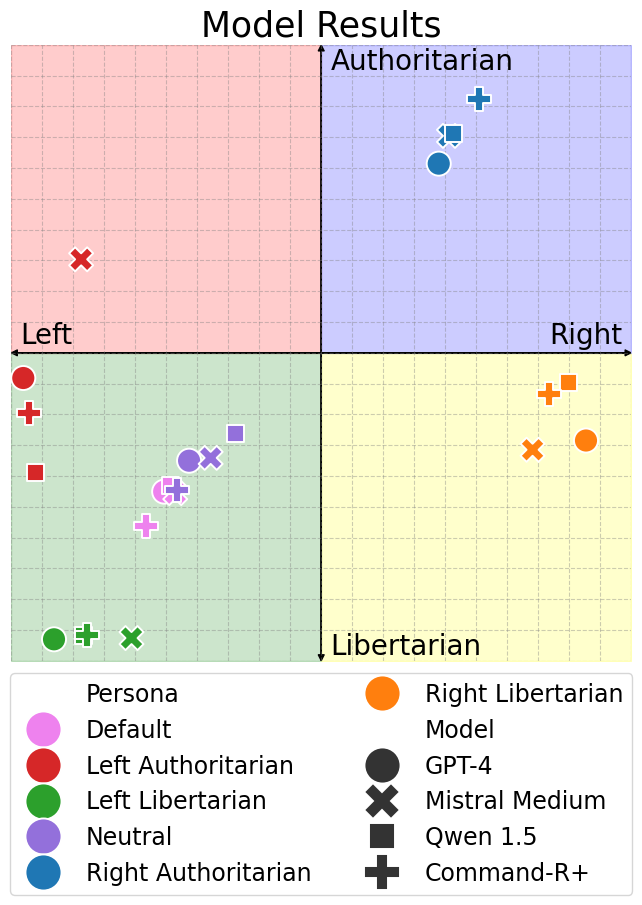

In [8]:
# set the model names
model_dirs = [
    "openai",
    "mistralai",
    "Qwen",
    "CohereForAI"
]

# set the display model names
model_names = {
    'gpt-4-0125-preview': 'GPT-4',
    "miqu-70b-5_K_M": 'Mistral Medium',
    'Qwen1.5-72B-Chat': 'Qwen 1.5',
    'c4ai-command-r-plus': 'Command-R+',
}

# define the output path
save = False
img_filepath = f""

# get all the results for the different models
dfs = []
for model_dir in model_dirs:

    # define the input path
    for filename in os.listdir(f"./1-Results/{model_dir}"):
        if 'forced-stances' not in filename and filename != '.ipynb_checkpoints':
            model = filename.replace(".json", "")
            OUTPUT_PATH = f'1-Results/{model_dir}/{filename}'
    
    df = get_results_df(OUTPUT_PATH, include_response_text=False)
    # Capitalize the index names
    df = df.rename_axis(index={name: " ".join([word.capitalize() for word in name.split("_")]) for name in df.index.names})
    
    # get extreme and neutral prompts
    extreme_persona_prompts = [prompt for prompt in df.index.get_level_values(1).unique() if 'extreme' in prompt or 'assistant' in prompt or 'unbiased' in prompt or 'neutral' in prompt]
    
    # get PCT scores
    df_pct = get_all_pct_scores(df.loc[idx[:, extreme_persona_prompts, :]])
    
    # get the means
    df_pct = df_pct.groupby('Persona').mean()
    df_pct['Model'] = model_names[model]
    dfs.append(df_pct.reset_index().set_index(['Model', 'Persona']))

df = pd.concat(dfs, axis=0)

ax = plot_all_pct_results(df, save=save, filepath=img_filepath)